# TF: Full Tensor Product

## Setup and Imports

In [19]:
import jax.numpy as jnp
import liesel.goose as gs
import liesel.model as lsl
import matplotlib.pyplot as plt
import numpy as np
import plotnine as p9
import tensorflow_probability.substrates.jax.distributions as tfd

import liesel_gam as gam

In [20]:
import jax

jax.config.update("jax_enable_x64", True)

In [21]:
df = gam.demo_data_ta(n=600, noise_sd=0.25, seed=42)
df_grid = gam.demo_data_ta(n=5000, grid=True)

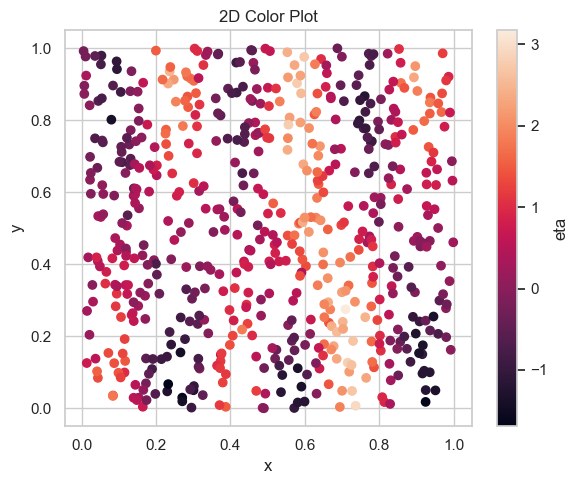

In [22]:
plt.figure(figsize=(6, 5))
plt.scatter(df["x"], df["y"], c=df["z"])
plt.xlabel("x")
plt.ylabel("y")
plt.title("2D Color Plot")
plt.colorbar(label="eta")
plt.tight_layout()
plt.show()

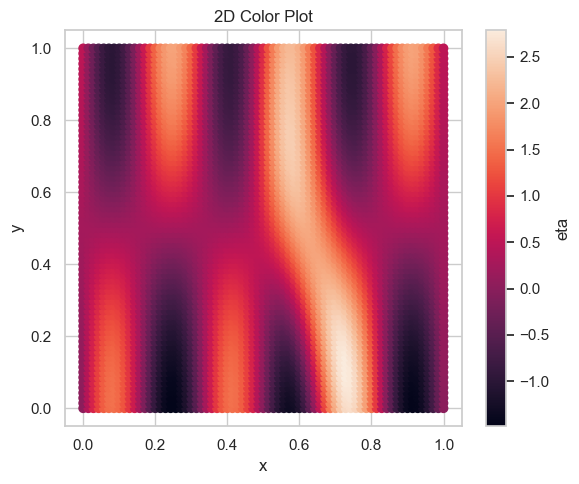

In [23]:
plt.figure(figsize=(6, 5))
plt.scatter(df_grid["x"], df_grid["y"], c=df_grid["eta"])
plt.xlabel("x")
plt.ylabel("y")
plt.title("2D Color Plot")
plt.colorbar(label="eta")
plt.tight_layout()
plt.show()

## Model Definition

### Setup response model

In [24]:
loc = gam.AdditivePredictor("$\\mu$")
scale = gam.AdditivePredictor("$\\sigma$", inv_link=jnp.exp)


z = lsl.Var.new_obs(
    value=df.z.to_numpy(),
    distribution=lsl.Dist(tfd.Normal, loc=loc, scale=scale),
    name="z",
)

In [25]:
tb = gam.TermBuilder.from_df(df)

In [26]:
psx = tb.ps("x", k=12)
psy = tb.ps("y", k=12)
loc += tb.tf(psx, psy)

### Build and plot model

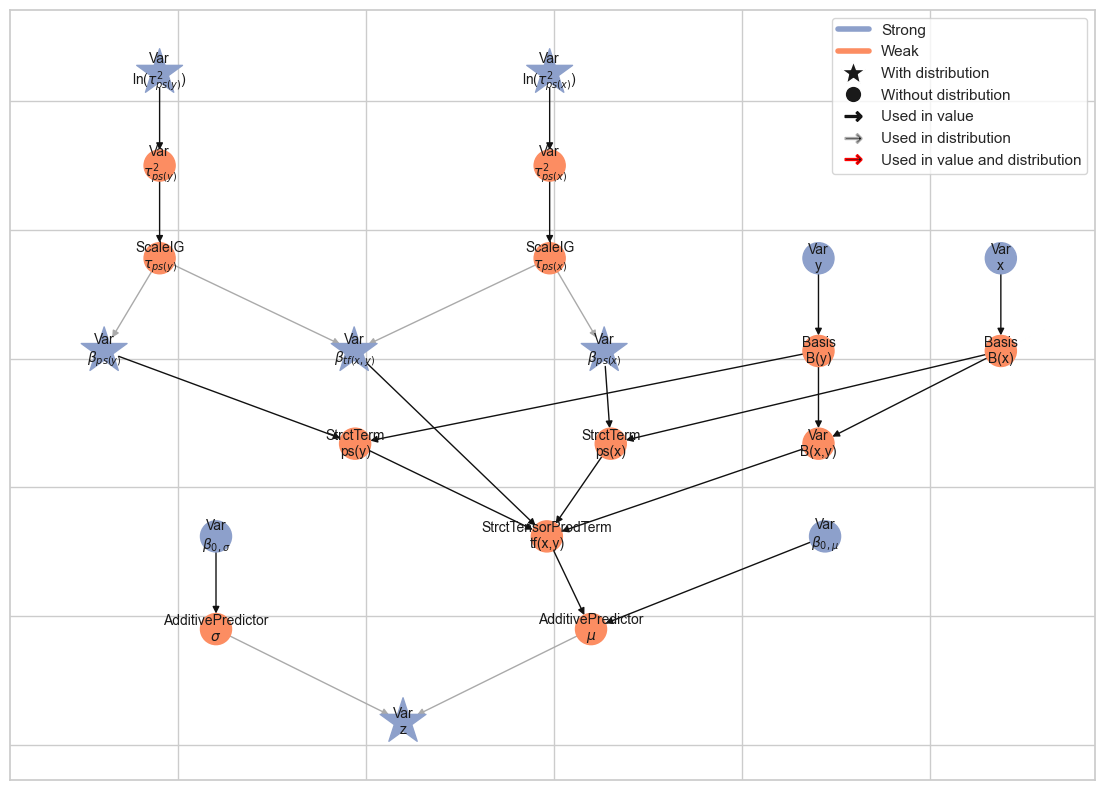

In [27]:
model = lsl.Model([z], to_float32=False)
model.plot_vars()

## Run MCMC

In [28]:
eb = gs.LieselMCMC(model).get_engine_builder(seed=1, num_chains=4)

eb.add_adaptation(3000)  # adaptation instead of burnin, because scales use HMC kernel
# eb.add_burnin(5000)  # adaptation instead of burnin, because scales use HMC kernel
eb.add_posterior(11_000, thinning=10)

engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys '$\\beta_{0,\\sigma}$', '$\\beta_{0,\\mu}$', '$\\beta_{tf(x,y)}$', 'ln($\\tau_{ps(y)}^2$)', 'ln($\\tau_{ps(x)}^2$)', '$\\beta_{ps(y)}$', '$\\beta_{ps(x)}$'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 300 transitions, 25 jitted together
100%|████████████████████████████████████████| 12/12 [00:08<00:00,  1.48chunk/s]
liesel.goose.engine - WARNING - Errors per chain for kernel_03: 26, 17, 24, 18 / 300 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_04: 18, 27, 13, 17 / 300 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|█████████████████████████████████████████| 1/1 [00:00<00:00, 611.68chunk/s]
liesel.goose.engine - WARNING

### MCMC summary

In [29]:
summary = gs.Summary(results)

diagnostics = (
    summary.to_dataframe()
    .reset_index()
    .loc[:, ["variable", "rhat", "ess_bulk", "ess_tail"]]
    .groupby("variable", as_index=False)
    .agg(
        ess_bulk_min=("ess_bulk", "min"),
        ess_bulk_median=("ess_bulk", "median"),
        ess_tail_min=("ess_tail", "min"),
        ess_tail_median=("ess_tail", "median"),
        rhat_max=("rhat", "max"),
        rhat_median=("rhat", "median"),
    )
)
diagnostics

,variable,ess_bulk_min,ess_bulk_median,ess_tail_min,ess_tail_median,rhat_max,rhat_median
0,"$\beta_{0,\mu}$",3667.153507,3667.153507,4143.494652,4143.494652,1.000081,1.000081
1,"$\beta_{0,\sigma}$",3237.887897,3237.887897,4234.954461,4234.954461,1.000708,1.000708
2,$\beta_{ps(x)}$,2654.456086,2950.001567,3329.684058,3773.720469,1.003448,1.002228
3,$\beta_{ps(y)}$,1715.689416,3458.595736,2951.163691,3706.319678,1.001731,1.000516
4,"$\beta_{tf(x,y)}$",562.751795,1610.338148,288.872165,2004.276465,1.007987,1.002640
5,ln($\tau_{ps(x)}^2$),357.905826,357.905826,1083.738474,1083.738474,1.009642,1.009642
6,ln($\tau_{ps(y)}^2$),210.415649,210.415649,352.794218,352.794218,1.010037,1.010037


In [30]:
summary.error_df()

count sample_size  \
kernel    error_code error_msg            phase                         
kernel_03 1          divergent transition warmup      630       12000   
                                          posterior     0        4400   
kernel_04 1          divergent transition warmup      648       12000   
                                          posterior     0        4400   

                                                    sample_size_total relative  
kernel    error_code error_msg            phase                                 
kernel_03 1          divergent transition warmup                12000   0.0525  
                                          posterior             44000      0.0  
kernel_04 1          divergent transition warmup                12000    0.054  
                                          posterior             44000      0.0

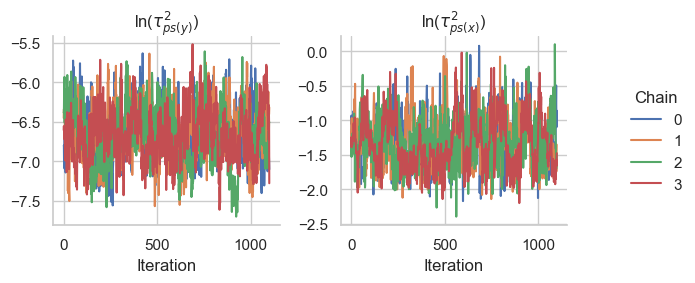

In [31]:
gs.plot_trace(results, [n for n in model.parameters if "tau" in n])

## Predictions

In [32]:
samples = results.get_posterior_samples()

### Plot

In [ ]:
gam.plot_2d_smooth(model.vars["tf(x,y)"], samples, ngrid=100)

### Predict variables at new x values

In [33]:
predictions = model.predict(
    samples=samples,
    predict=["tf(x,y)", "$\\mu$"],
    newdata={"x": df_grid.x.to_numpy(), "y": df_grid.y.to_numpy()},
)

predictions_summary = (
    gs.SamplesSummary(predictions, which=["mean", "quantiles"])
    .to_dataframe()
    .reset_index()
)

In [34]:
predictions_summary["x"] = np.tile(df_grid.x.to_numpy(), len(predictions))
predictions_summary["y"] = np.tile(df_grid.y.to_numpy(), len(predictions))

In [35]:
predictions_summary.head()

,variable,var_fqn,var_index,sample_size,mean,q_0.05,q_0.5,q_0.95,x,y
0,$\mu$,$\mu$[0],"(0,)",4400,0.183780,-0.960436,0.194830,1.308365,0.000000,0.0
1,$\mu$,$\mu$[1],"(1,)",4400,0.577247,-0.326586,0.575744,1.464964,0.014286,0.0
2,$\mu$,$\mu$[2],"(2,)",4400,0.931156,0.203578,0.931666,1.651620,0.028571,0.0
3,$\mu$,$\mu$[3],"(3,)",4400,1.230964,0.641704,1.226999,1.833733,0.042857,0.0
4,$\mu$,$\mu$[4],"(4,)",4400,1.463612,0.973566,1.462210,1.967166,0.057143,0.0


### Plot predictions

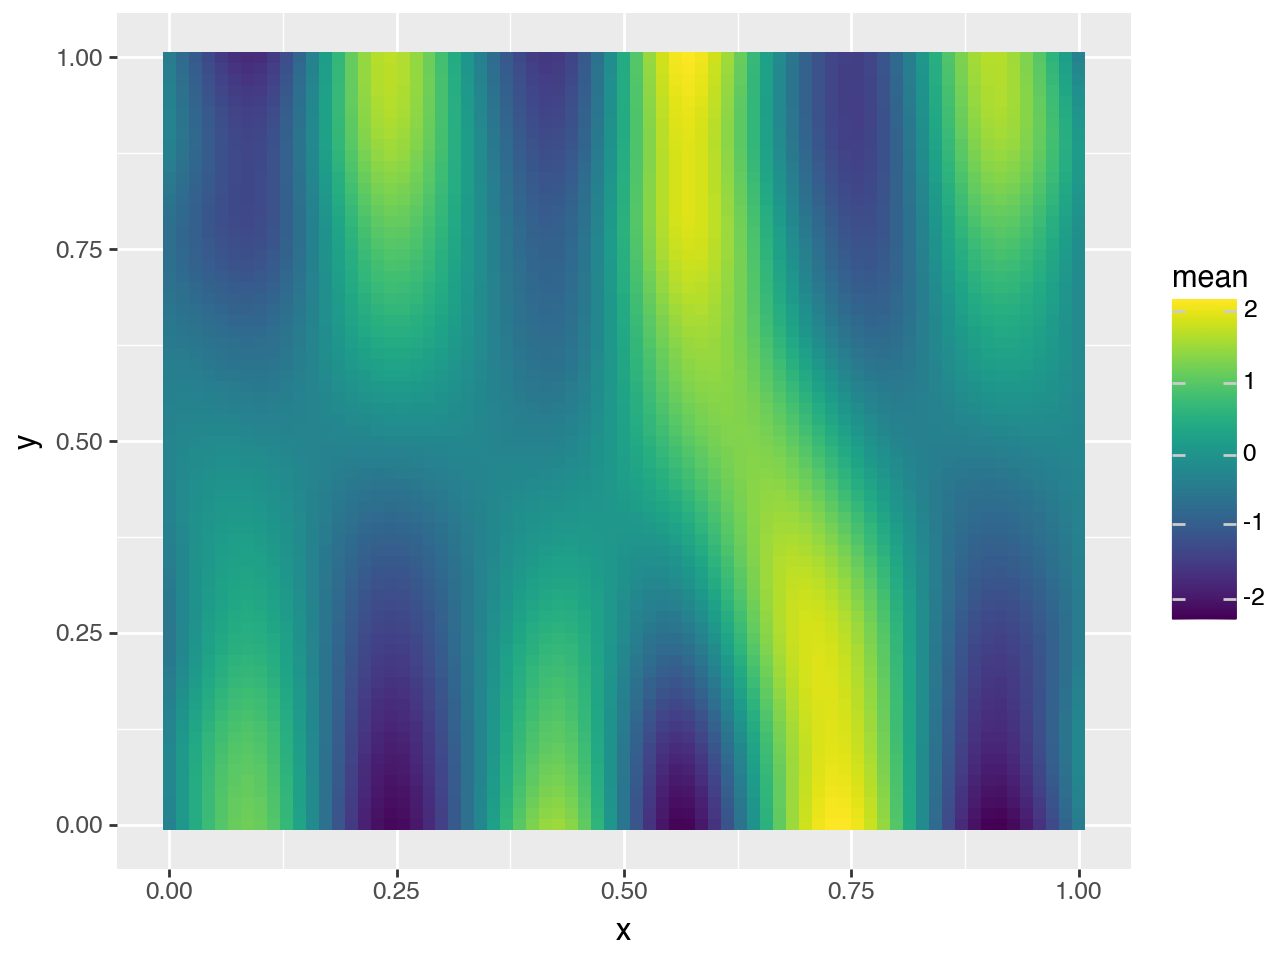

In [40]:
select = predictions_summary["variable"].isin(["tf(x,y)"])
(p9.ggplot(predictions_summary[select]) + p9.geom_tile(p9.aes("x", "y", fill="mean")))

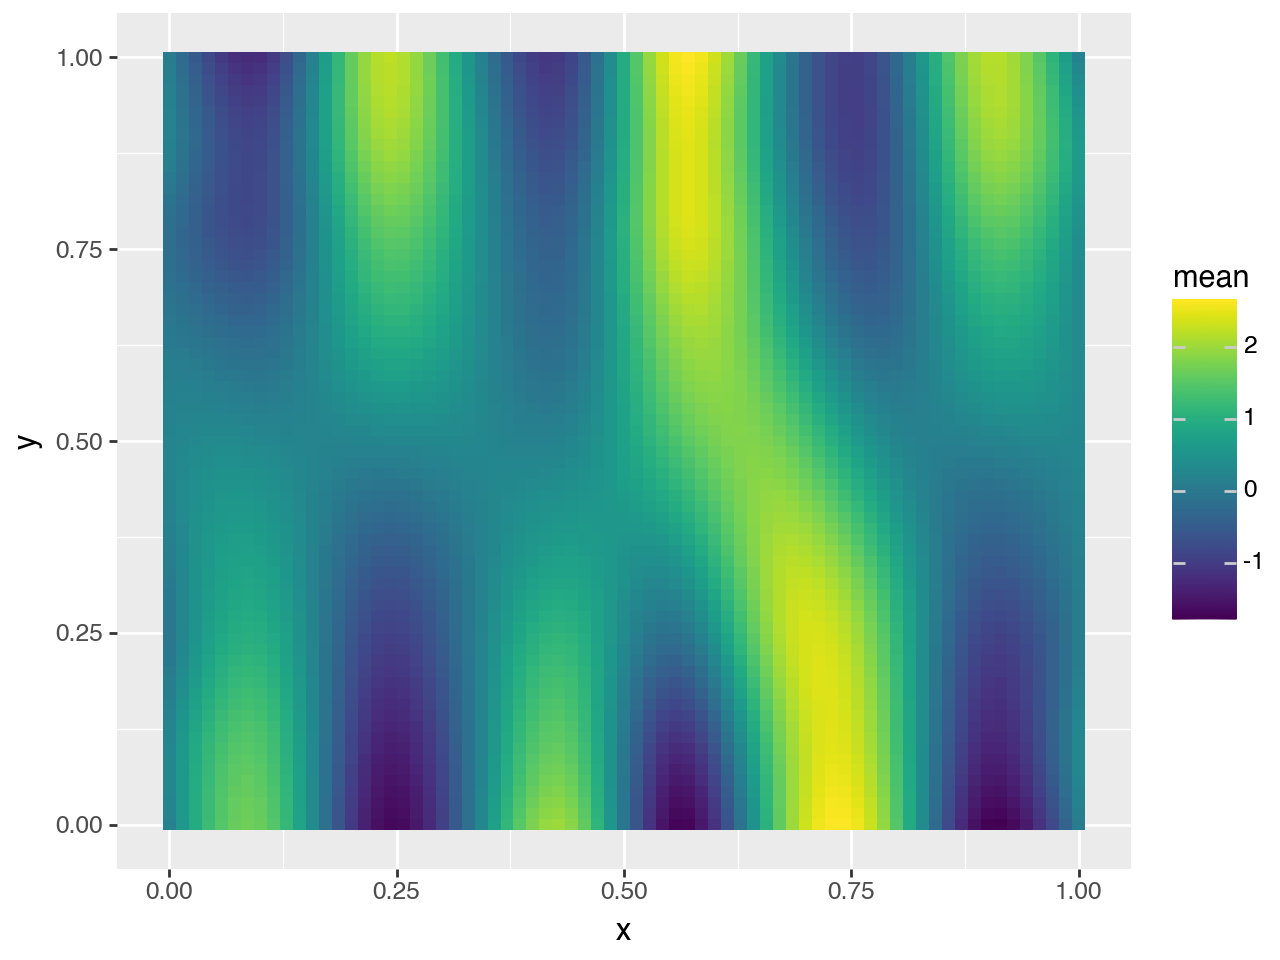

In [41]:
select = predictions_summary["variable"].isin(["$\\mu$"])
(p9.ggplot(predictions_summary[select]) + p9.geom_tile(p9.aes("x", "y", fill="mean")))

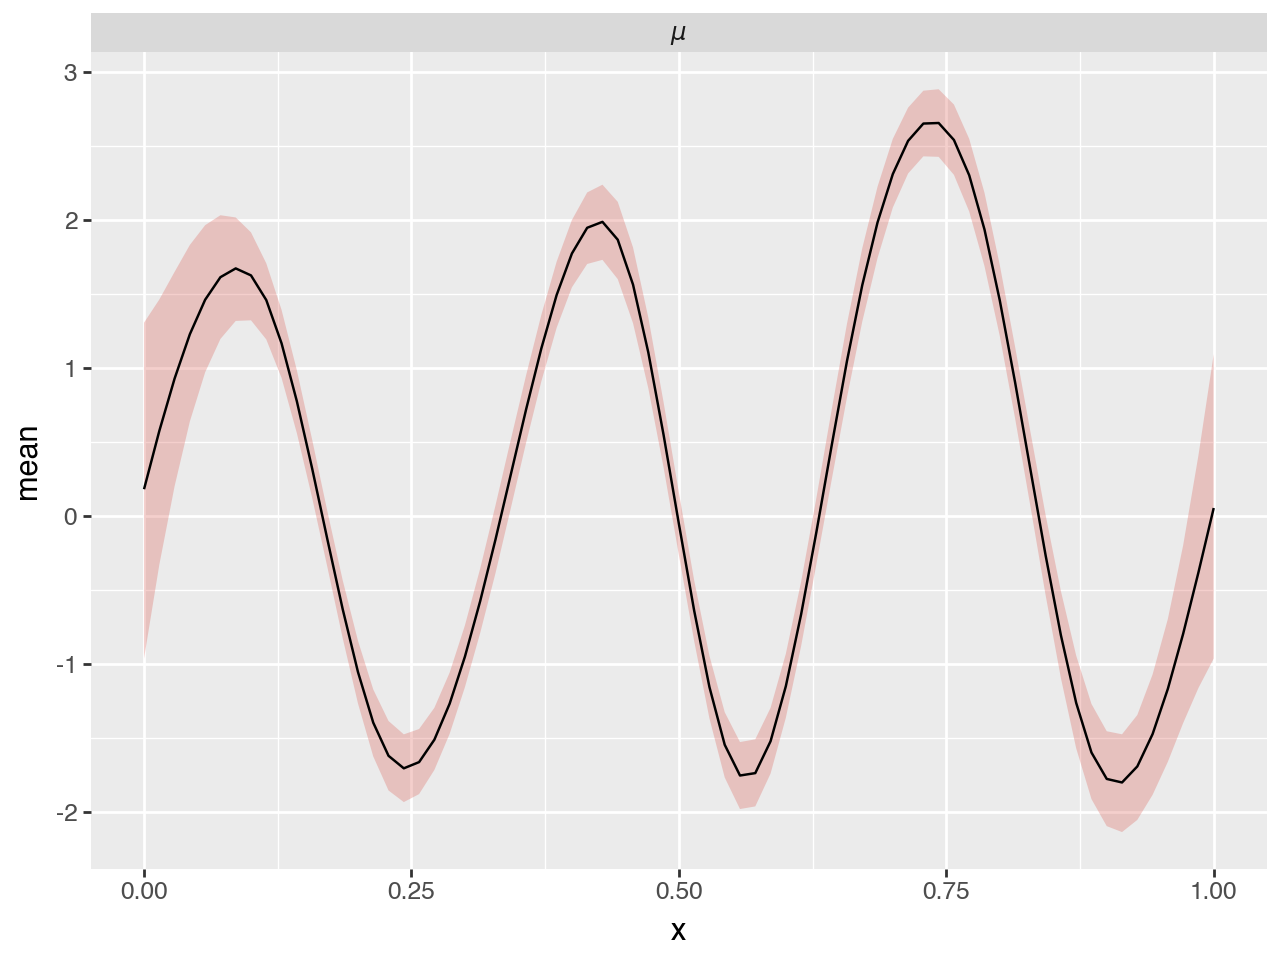

In [42]:
select = predictions_summary["variable"].isin(["$\\mu$"])
(
    p9.ggplot(predictions_summary[select].query("y == 0.0"))
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95", fill="variable"), alpha=0.3
    )
    + p9.geom_line(p9.aes("x", "mean"))
    + p9.facet_wrap("~variable", scales="free_y", ncol=1)
    + p9.guides(fill="none")
)

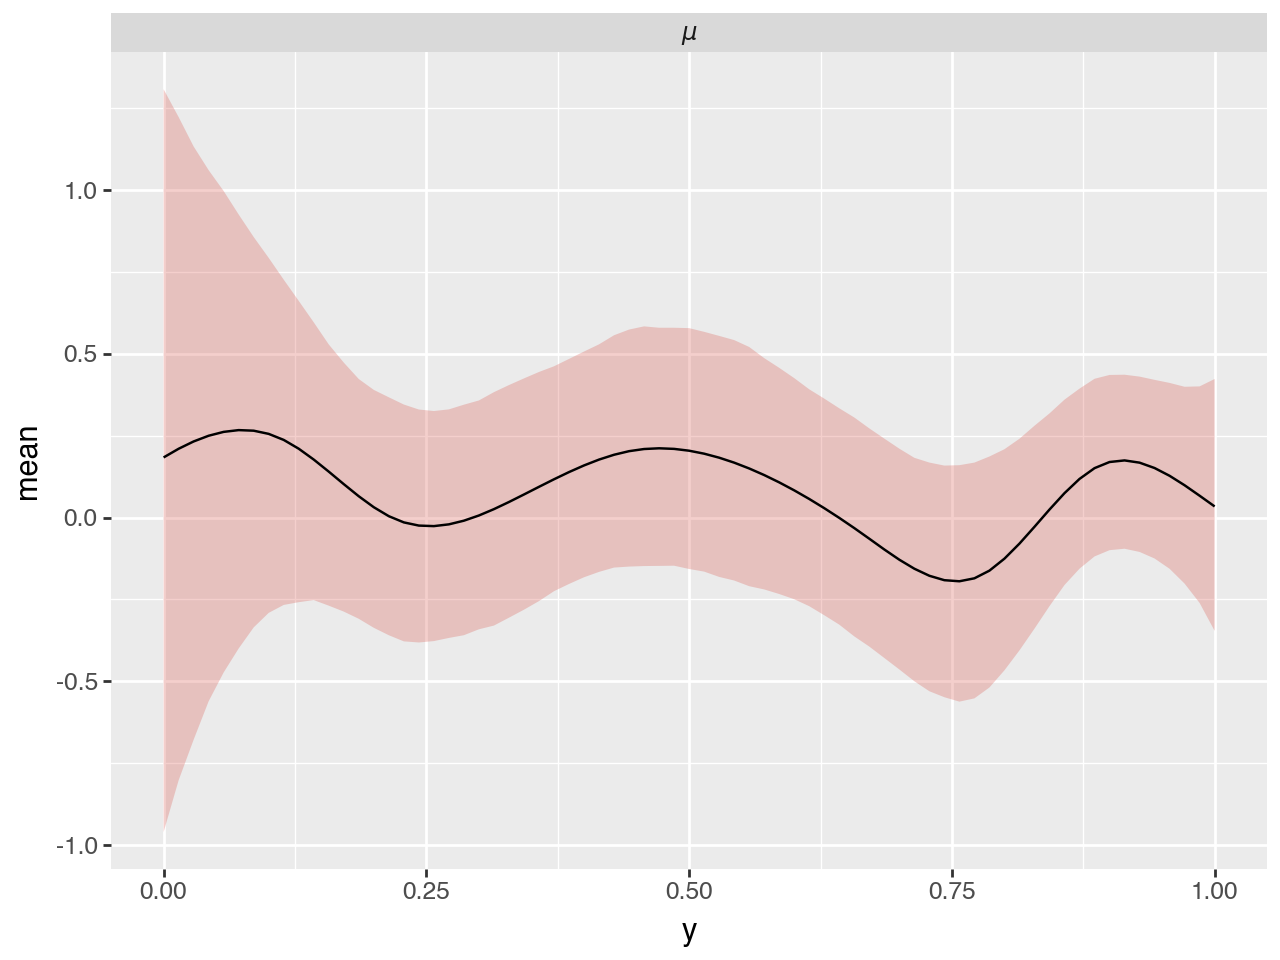

In [43]:
select = predictions_summary["variable"].isin(["$\\mu$"])
(
    p9.ggplot(predictions_summary[select].query("x == 0.0"))
    + p9.geom_ribbon(
        p9.aes("y", ymin="q_0.05", ymax="q_0.95", fill="variable"), alpha=0.3
    )
    + p9.geom_line(p9.aes("y", "mean"))
    + p9.facet_wrap("~variable", scales="free_y", ncol=1)
    + p9.guides(fill="none")
)